In [1]:
import numpy as np, numpy.random as npr, torch.nn as nn, timeit, torch, pystan as ps, arviz
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import plot, show, legend
from samplers import *

#### Generate data:

In [2]:
n_in = 1
n_out = 2

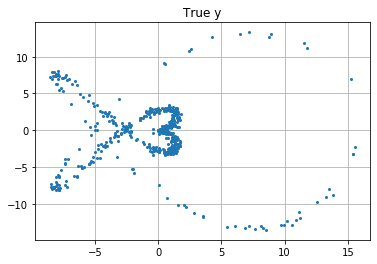

In [3]:
error_sigma2 = 0.05
dd = np.load("model1.npy")
X, Y = dd.item()['X'], dd.item()['Y']
X.requires_grad = True
plt.plot(list(Y[:,0]), list(Y[:,1]), 'o', markersize=2)
plt.grid(True)
plt.title("True y")
criterion = nn.MSELoss()
Nobs = np.shape(X)[0]

#### Compile Stan function:

In [4]:
sm = ps.StanModel(file="nn_fixedmodel.stan")

CRITICAL:pystan:Unable to read file specified by `file`.


FileNotFoundError: [Errno 2] No such file or directory: 'nn_fixedmodel.stan'

#### Run optimisation for NN:

In [5]:
n_h1 = 50
model = nn.Sequential(nn.Linear(n_in, n_h1), nn.Tanh(), nn.Linear(n_h1, n_out))
def init_normal(m) :
    if type(m) == nn.Linear :
        nn.init.normal_(m.weight)

In [6]:
model.apply(init_normal)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, nesterov=True)
n_iter = 50_000
start = time()
for epoch in range(n_iter):
    y_pred = model(X)
    loss = criterion(y_pred, Y)
    if (epoch+1)%(n_iter/10) == 0 :
        print("Epoch: %d; loss: %.3f; time: %.1f mins" % (epoch+1, loss.item(), (time()-start)/60))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 5000; loss: 0.471; time: 0.1 mins
Epoch: 10000; loss: 0.217; time: 0.1 mins
Epoch: 15000; loss: 0.131; time: 0.2 mins
Epoch: 20000; loss: 0.095; time: 0.2 mins
Epoch: 25000; loss: 0.076; time: 0.3 mins
Epoch: 30000; loss: 0.067; time: 0.3 mins
Epoch: 35000; loss: 0.061; time: 0.4 mins
Epoch: 40000; loss: 0.058; time: 0.4 mins
Epoch: 45000; loss: 0.055; time: 0.5 mins
Epoch: 50000; loss: 0.054; time: 0.5 mins


In [7]:
pm = []
for name, param in model.named_parameters():
    if param.requires_grad:
        pm.append(param.data.numpy())
weights_1, bias_1, weights_2, bias_2 = pm

#### Run sampling algorithm:

In [8]:
data = dict(Nobs=Nobs, 
            in_dim=n_in, 
            out_dim=n_out, 
            hidden_dim_1=n_h1,
            weights_1=weights_1.transpose(),
            bias_1=bias_1,
            weights_2=weights_2.transpose(),
            bias_2=bias_2,
            y=Y.detach().numpy())

In [9]:
control = dict(adapt_delta=0.9, max_treedepth=12)
fit = sm.sampling(data=data, thin=5, n_jobs=1, init="random", iter=10_000, control=control, chains=1)
print(fit);

Inference for Stan model: anon_model_d7880e1c6ffaf15cd85d158ad294814b.
1 chains, each with iter=10000; warmup=5000; thin=5; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
X[1,1]         -1.4  3.1e-3    0.1  -1.59  -1.47  -1.39  -1.32  -1.18   1081    1.0
X[2,1]         0.04    0.01   0.33   -0.6  -0.19   0.05   0.29   0.65    913    1.0
X[3,1]         0.81  7.2e-3   0.23   0.12   0.71   0.84   0.96   1.13    991    1.0
X[4,1]        -1.37  3.6e-3   0.12  -1.58  -1.45  -1.37  -1.29  -1.13   1035    1.0
X[5,1]         0.21  9.9e-3   0.33   -0.4  -0.05   0.24   0.47    0.8   1091    1.0
X[6,1]         -0.5  9.4e-3   0.28  -0.95  -0.69  -0.56  -0.36   0.21    926    1.0
X[7,1]        -0.79  8.0e-3   0.25  -1.16  -0.96  -0.82  -0.67  -0.08    981    1.0
X[8,1]         0.64  8.3e-3   0.27  -0.06   0.52    0.7   0.81   1.05   1024    1.0
X[9,1]        -1.23  3.3e-3   0.11  -1.44   -1.3  -1.2

In [10]:
(fit.get_sampler_params())

[OrderedDict([('accept_stat__',
               array([1.        , 1.        , 0.86411742, ..., 0.84440332, 0.91651767,
                      0.95093368])),
              ('stepsize__',
               array([0.015625  , 0.0057934 , 0.01777241, ..., 0.17979536, 0.17979536,
                      0.17979536])),
              ('treedepth__', array([3., 9., 7., ..., 5., 4., 4.])),
              ('n_leapfrog__',
               array([  7., 511., 127., ...,  31.,  15.,  31.])),
              ('divergent__', array([0., 0., 0., ..., 0., 0., 0.])),
              ('energy__',
               array([3587.84882198, 1551.92673822,  982.35799606, ...,  775.35163883,
                       715.13134518,  735.81734793]))])]

#### Plot final:

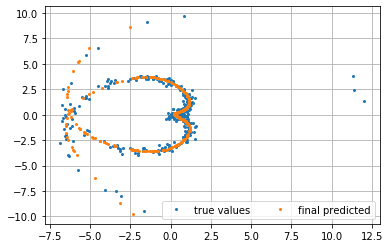

In [11]:
trace = fit.extract()
y_pred = np.matmul(np.tanh(trace['X'][-1]*weights_1.transpose() + bias_1), weights_2.transpose()) + bias_2
plt.plot(list(Y[:,0]), list(Y[:,1]), 'o', markersize=2, label="true values")
plt.plot(y_pred[:,0],y_pred[:,1], 'o', markersize=2, label="final predicted")
plt.grid(True)
plt.legend(ncol=2)

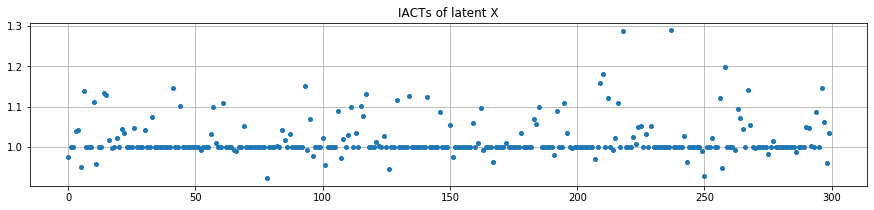

In [12]:
iact_x = [gewer_estimate_IAT(trace['X'][:,i,0]) for i in range(np.shape(trace['X'])[-2])]
plt.figure(figsize=(15,3))
plt.plot(iact_x, 'o', markersize=4)
plt.grid(True)
plt.title("IACTs of latent X");

### Predictive distribution:

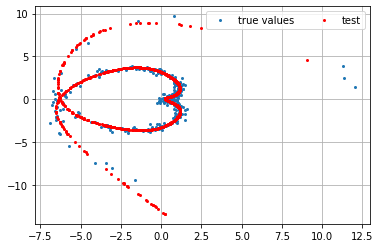

In [32]:
Ntest = 1_000
X_test = npr.randn(Ntest, n_in)
y_test = np.matmul(np.tanh(X_test*(weights_1.transpose())+bias_1),weights_2.transpose()) + bias_2
plt.plot(list(Y[:,0]), list(Y[:,1]), 'o', markersize=2, label="true values")
plt.plot(y_test[:,0],y_test[:,1], 'ro', markersize=2, label="test")
plt.grid(True)
plt.legend(ncol=2)